# Extreme Heat and US Mental Health: A Geospatial and Spatial Econometric Analysis

**Name**: Sanne Glastra  
**Date**: 2025-05-20  
**File**: `spatial_econometric_analysis.ipynb`

### Description
This analysis explores the relationship between extreme heat days and mental health outcomes for the U.S. in 2024 at the zip code level. It utilizes **Spatial Lag models** and **Global Moran's I** to account for geographic dependence and identify spatial clustering of poor health outcomes.

# 1. Import Libraries

In [104]:
import numpy as np
import libpysal as lps
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import os
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import skgstat as skg
from pysal.lib import weights
import libpysal
import esda
import giddy
from esda.moran import Moran
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation
from pysal.model import spreg
from libpysal.weights import Queen

In [105]:
# check working directory
os.getcwd()

'/Users/sanneglastra/Documents/school/columbia/spring 2025/advanced gis/final-project'

# 2. Load Data

#### a: Load mental health + control data
Data was collected from the CDC Heat Tracker, a tool developed to monitor heat-related risks and trends across the U.S. 

In [106]:
# load cdc data (mental health variables and controls)
cdc = pd.read_excel("HHI_Data_2024_United_States.xlsx", engine="openpyxl")

In [107]:
cdc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32195 entries, 0 to 32194
Data columns (total 75 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   STATEFP10       32195 non-null  int64  
 1   STATE           32195 non-null  object 
 2   STATE_ABV       32195 non-null  object 
 3   ZCTA            32195 non-null  int64  
 4   GEOID10         32195 non-null  int64  
 5   MULTI_STATE     32195 non-null  int64  
 6   POP             32195 non-null  int64  
 7   PR_HRI          32195 non-null  int64  
 8   F_HRI           32195 non-null  float64
 9   LOW_EMS         32195 non-null  int64  
 10  P_NEHD          32195 non-null  float64
 11  PR_NEHD         32195 non-null  float64
 12  HHB_SCORE       32195 non-null  float64
 13  HHB_RANK        32195 non-null  float64
 14  P_CHD           32195 non-null  float64
 15  PR_CHD          32195 non-null  float64
 16  F_CHD           32195 non-null  int64  
 17  P_OBS           32195 non-null 

#### b: Load temperature data
Max temperature will be used as a proxy for extreme heat days (https://www.wri.org/insights/future-extreme-heat-cities-data).
Data was collected from PRISM Climate Data (https://prism.oregonstate.edu/recent/). 

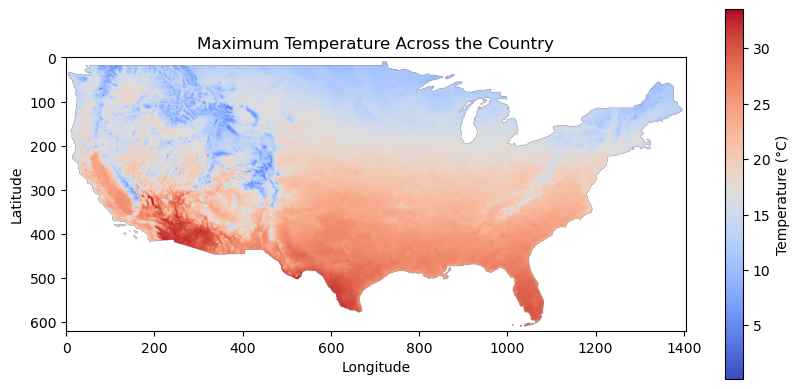

In [108]:
# Specify file path
tmax_raster = 'PRISM_tmax_provisional_4kmM3_2024_bil.bil'

# Open the file and read data
with rasterio.open(tmax_raster) as src:
    raster_data = src.read(1)  # Read the first band
    
    # Replace -9999 with NaN
    raster_data = np.where(raster_data == -9999, np.nan, raster_data)

    # Get the affine transformation
    affine = src.transform  

# Plotting the raster data
plt.figure(figsize=(10, 8))
im = plt.imshow(raster_data, cmap='coolwarm', origin='upper')
plt.colorbar(im, label='Temperature (°C)', shrink=0.6)  # Adjust shrink to make it shorter
plt.title('Maximum Temperature Across the Country')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# 3. Prepare Data

#### a: Convert PRISM raster file to get max temp by zip code

In [109]:
# Load ZIP code boundaries
zipcodes = gpd.read_file('zips.shp')

In [110]:
# View df
zipcodes.head()

,ZCTA5CE20,AFFGEOID20,GEOID20,NAME20,LSAD20,ALAND20,AWATER20,NAME,totalE,totalM,whiteE,whiteM,pct_white,geometry
0,15301,860Z200US15301,15301,15301,Z5,315861121.0,709775.0,ZCTA5 15301,50180.0,800.0,44206.0,876.0,88.094859,"POLYGON ((-80.3686 40.21895, -80.35493 40.2440..."
1,15658,860Z200US15658,15658,15658,Z5,238683518.0,759690.0,ZCTA5 15658,8114.0,477.0,7772.0,471.0,95.785063,"POLYGON ((-79.34323 40.17201, -79.3375 40.1777..."
2,15601,860Z200US15601,15601,15601,Z5,208874774.0,337008.0,ZCTA5 15601,55670.0,1383.0,51710.0,1516.0,92.886653,"POLYGON ((-79.66911 40.28912, -79.6626 40.2858..."
3,17720,860Z200US17720,17720,17720,Z5,8797202.0,2822.0,ZCTA5 17720,271.0,81.0,271.0,81.0,100.000000,"POLYGON ((-77.23026 41.18926, -77.2249 41.1904..."
4,18843,860Z200US18843,18843,18843,Z5,3620019.0,0.0,ZCTA5 18843,349.0,226.0,313.0,224.0,89.684814,"POLYGON ((-75.90554 41.79017, -75.90545 41.792..."


<Axes: >

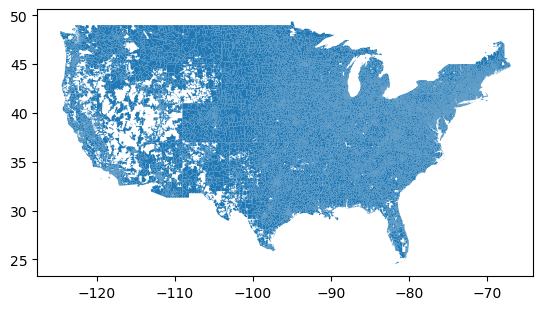

In [111]:
# Define the bounding box for the continental U.S.
min_longitude = -125.0
max_longitude = -66.9
min_latitude = 24.5
max_latitude = 49.3

# Filter zipcodes to include only those within the bounding box
zipcodes_continental_us = zipcodes.cx[min_longitude:max_longitude, min_latitude:max_latitude]

# Plot the filtered data
zipcodes_continental_us.plot()

In [112]:
# Compute zonal statistics (max temperature per ZIP code)
stats = zonal_stats(zipcodes_continental_us, raster_data, affine=affine, stats=["max"])

In [113]:
# Add results to GeoDataFrame
zipcodes_continental_us = zipcodes_continental_us.copy()
zipcodes_continental_us["max_temp"] = [s["max"] for s in stats]

<Axes: >

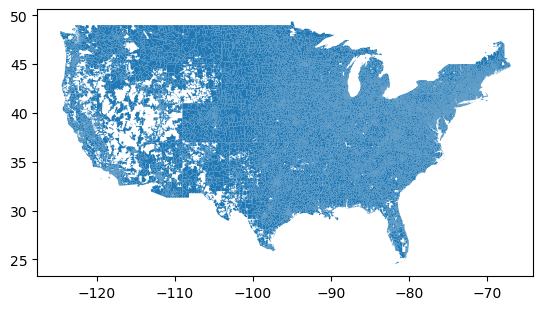

In [114]:
zipcodes_continental_us.plot()

In [115]:
zipcodes_continental_us.head()

,ZCTA5CE20,AFFGEOID20,GEOID20,NAME20,LSAD20,ALAND20,AWATER20,NAME,totalE,totalM,whiteE,whiteM,pct_white,geometry,max_temp
0,15301,860Z200US15301,15301,15301,Z5,315861121.0,709775.0,ZCTA5 15301,50180.0,800.0,44206.0,876.0,88.094859,"POLYGON ((-80.3686 40.21895, -80.35493 40.2440...",18.400049
1,15658,860Z200US15658,15658,15658,Z5,238683518.0,759690.0,ZCTA5 15658,8114.0,477.0,7772.0,471.0,95.785063,"POLYGON ((-79.34323 40.17201, -79.3375 40.1777...",17.347042
2,15601,860Z200US15601,15601,15601,Z5,208874774.0,337008.0,ZCTA5 15601,55670.0,1383.0,51710.0,1516.0,92.886653,"POLYGON ((-79.66911 40.28912, -79.6626 40.2858...",18.043207
3,17720,860Z200US17720,17720,17720,Z5,8797202.0,2822.0,ZCTA5 17720,271.0,81.0,271.0,81.0,100.000000,"POLYGON ((-77.23026 41.18926, -77.2249 41.1904...",NaN
4,18843,860Z200US18843,18843,18843,Z5,3620019.0,0.0,ZCTA5 18843,349.0,226.0,313.0,224.0,89.684814,"POLYGON ((-75.90554 41.79017, -75.90545 41.792...",NaN


#### b: Prepare CDC Data

In [116]:
# make sure all zcta values are 5 digit
cdc['ZCTA'] = cdc['ZCTA'].astype(str).str.zfill(5)

In [117]:
cdc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32195 entries, 0 to 32194
Data columns (total 75 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   STATEFP10       32195 non-null  int64  
 1   STATE           32195 non-null  object 
 2   STATE_ABV       32195 non-null  object 
 3   ZCTA            32195 non-null  object 
 4   GEOID10         32195 non-null  int64  
 5   MULTI_STATE     32195 non-null  int64  
 6   POP             32195 non-null  int64  
 7   PR_HRI          32195 non-null  int64  
 8   F_HRI           32195 non-null  float64
 9   LOW_EMS         32195 non-null  int64  
 10  P_NEHD          32195 non-null  float64
 11  PR_NEHD         32195 non-null  float64
 12  HHB_SCORE       32195 non-null  float64
 13  HHB_RANK        32195 non-null  float64
 14  P_CHD           32195 non-null  float64
 15  PR_CHD          32195 non-null  float64
 16  F_CHD           32195 non-null  int64  
 17  P_OBS           32195 non-null 

In [118]:
selected_columns = ['STATE', 'ZCTA','P_MNTHL', 'P_NEHD', 'SOCIODEM_SCORE', 'P_IMPERV', 'P_TREEC', 'P_MOBILE', 'P_NOVEH', 'P_PM25']
cdc_subset = cdc[selected_columns]
cdc_subset.head()

,STATE,ZCTA,P_MNTHL,P_NEHD,SOCIODEM_SCORE,P_IMPERV,P_TREEC,P_MOBILE,P_NOVEH,P_PM25
0,MA,01001,16.3,17.200,0.4952,24.875335,37.492276,0.4,8.6,0.0
1,MA,01002,20.2,17.225,0.3694,4.647261,65.999638,0.1,9.7,0.0
2,MA,01003,33.8,17.000,0.4661,54.066766,23.606311,0.0,0.0,0.0
3,MA,01005,16.2,17.200,0.2571,2.074950,70.617445,3.5,3.9,0.0
4,MA,01007,14.7,-999.000,0.3126,2.700549,62.296608,5.9,5.1,0.0


In [119]:
# evaluate variables
cdc['P_NEHD'].describe() # need to remove -999 value (or turn into NA)

count    32195.000000
mean       -14.018329
std        161.880364
min       -999.000000
25%          9.000000
50%         12.640000
75%         15.900000
max         30.400000
Name: P_NEHD, dtype: float64

In [120]:
cdc['P_MNTHL'].describe() 

count    32195.000000
mean        16.260087
std          2.878000
min          4.700000
25%         14.300000
50%         16.100000
75%         17.900000
max         41.100000
Name: P_MNTHL, dtype: float64

In [121]:
cdc['ZCTA'].describe() 

count     32195
unique    32092
top       58653
freq          2
Name: ZCTA, dtype: object

In [122]:
cdc['SOCIODEM_SCORE'].describe()  # remove -999 and convert to NA. multiply by 100. 

count    32195.000000
mean        -2.057135
std         50.378489
min       -999.000000
25%          0.389600
50%          0.493300
75%          0.592800
max          0.929500
Name: SOCIODEM_SCORE, dtype: float64

In [123]:
cdc['P_IMPERV'].describe() 

count    32195.000000
mean        10.899188
std         17.923651
min          0.015458
25%          0.848760
50%          1.936375
75%         11.753481
max         95.262121
Name: P_IMPERV, dtype: float64

In [124]:
cdc['P_TREEC'].describe()  

count    32195.000000
mean        29.281165
std         24.118272
min          0.000000
25%          6.973154
50%         24.115403
75%         49.136191
max         88.233765
Name: P_TREEC, dtype: float64

In [125]:
cdc['P_MOBILE'].describe()  # remove -999 and convert to NA.

count    32195.000000
mean         3.359251
std         92.099744
min       -999.000000
25%          1.000000
50%          7.000000
75%         17.700000
max        100.000000
Name: P_MOBILE, dtype: float64

In [126]:
cdc['P_NOVEH'].describe()  # remove -999 and convert to NA.

count    32195.000000
mean        -3.795707
std         99.097404
min       -999.000000
25%          1.700000
50%          4.000000
75%          7.300000
max        100.000000
Name: P_NOVEH, dtype: float64

In [127]:
cdc['P_PM25'].describe() 

count    32195.000000
mean         0.934845
std          2.853574
min          0.000000
25%          0.000000
50%          0.000000
75%          0.333333
max         41.666667
Name: P_PM25, dtype: float64

In [128]:
# replace all -999 with NA
cdc.replace(-999, np.nan, inplace=True)

In [129]:
# multiply some columns by 100 to create even scale
cdc['SOCIODEM_SCORE'] = cdc['SOCIODEM_SCORE'] * 100

#### c: Prepare PRISM / Zip Code Data

In [130]:
# make sure all zcta values are 5 digit
zipcodes_continental_us.loc[:, 'ZCTA5CE20'] = zipcodes_continental_us['ZCTA5CE20'].astype(str).str.zfill(5)

In [131]:
# select columns of interest
zipcodes_subset = zipcodes_continental_us[["ZCTA5CE20", "geometry", "max_temp", "pct_white"]]
zipcodes_subset.head()

,ZCTA5CE20,geometry,max_temp,pct_white
0,15301,"POLYGON ((-80.3686 40.21895, -80.35493 40.2440...",18.400049,88.094859
1,15658,"POLYGON ((-79.34323 40.17201, -79.3375 40.1777...",17.347042,95.785063
2,15601,"POLYGON ((-79.66911 40.28912, -79.6626 40.2858...",18.043207,92.886653
3,17720,"POLYGON ((-77.23026 41.18926, -77.2249 41.1904...",NaN,100.000000
4,18843,"POLYGON ((-75.90554 41.79017, -75.90545 41.792...",NaN,89.684814


In [132]:
zipcodes_subset.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 33300 entries, 0 to 33790
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ZCTA5CE20  33300 non-null  object  
 1   geometry   33300 non-null  geometry
 2   max_temp   28067 non-null  float64 
 3   pct_white  32718 non-null  float64 
dtypes: float64(2), geometry(1), object(1)
memory usage: 1.3+ MB


#### d: Merge CDC and PRISM Datasets

In [133]:
# check number of observations
len(cdc_subset)

32195

In [134]:
# check number of observations
len(zipcodes_subset)

33300

In [135]:
# merge zipcodes df with cdc
full = pd.merge(cdc_subset, zipcodes_subset, left_on='ZCTA', right_on='ZCTA5CE20', how='left')
full.head()
len(full)

32195

In [136]:
# view all columns
full.info()
full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32195 entries, 0 to 32194
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   STATE           32195 non-null  object  
 1   ZCTA            32195 non-null  object  
 2   P_MNTHL         32195 non-null  float64 
 3   P_NEHD          32195 non-null  float64 
 4   SOCIODEM_SCORE  32195 non-null  float64 
 5   P_IMPERV        32195 non-null  float64 
 6   P_TREEC         32195 non-null  float64 
 7   P_MOBILE        32195 non-null  float64 
 8   P_NOVEH         32195 non-null  float64 
 9   P_PM25          32195 non-null  float64 
 10  ZCTA5CE20       32093 non-null  object  
 11  geometry        32093 non-null  geometry
 12  max_temp        27812 non-null  float64 
 13  pct_white       31928 non-null  float64 
dtypes: float64(10), geometry(1), object(3)
memory usage: 3.4+ MB


,STATE,ZCTA,P_MNTHL,P_NEHD,SOCIODEM_SCORE,P_IMPERV,P_TREEC,P_MOBILE,P_NOVEH,P_PM25,ZCTA5CE20,geometry,max_temp,pct_white
0,MA,01001,16.3,17.200,0.4952,24.875335,37.492276,0.4,8.6,0.0,01001,"POLYGON ((-72.66768 42.04502, -72.65772 42.050...",17.580507,86.874070
1,MA,01002,20.2,17.225,0.3694,4.647261,65.999638,0.1,9.7,0.0,01002,"POLYGON ((-72.54582 42.41014, -72.5442 42.4271...",16.989624,72.211437
2,MA,01003,33.8,17.000,0.4661,54.066766,23.606311,0.0,0.0,0.0,01003,"POLYGON ((-72.5334 42.38455, -72.53225 42.3954...",NaN,61.221705
3,MA,01005,16.2,17.200,0.2571,2.074950,70.617445,3.5,3.9,0.0,01005,"POLYGON ((-72.16838 42.44098, -72.16846 42.441...",16.500525,92.895947
4,MA,01007,14.7,-999.000,0.3126,2.700549,62.296608,5.9,5.1,0.0,01007,"POLYGON ((-72.47229 42.35146, -72.47138 42.351...",16.543917,86.933662


In [137]:
# count and inspect missing values
missing_data = full.isna().sum()
print(missing_data)

STATE                0
ZCTA                 0
P_MNTHL              0
P_NEHD               0
SOCIODEM_SCORE       0
P_IMPERV             0
P_TREEC              0
P_MOBILE             0
P_NOVEH              0
P_PM25               0
ZCTA5CE20          102
geometry           102
max_temp          4383
pct_white          267
dtype: int64


In [138]:
# remove rows with any missing values
full = full.dropna(axis=0, how='any', subset=None, inplace=False)
len(full)

27749

#### e: Create spatial dataframe and plot

In [139]:
# create new object crs -- setting coordinate reference system
crs = 'epsg:4326'

In [140]:
# combine full dataset with spatial points and crs -- adding spatial functionality to larger dataframe
full_sp = gpd.GeoDataFrame(full, 
                           crs = crs, 
                           geometry = full['geometry'])

In [145]:
# view spatial dataframe
full_sp.head()

,STATE,ZCTA,P_MNTHL,P_NEHD,SOCIODEM_SCORE,P_IMPERV,P_TREEC,P_MOBILE,P_NOVEH,P_PM25,ZCTA5CE20,geometry,max_temp,pct_white
0,MA,01001,16.3,17.200000,0.4952,24.875335,37.492276,0.4,8.6,0.0,01001,"POLYGON ((-72.66768 42.04502, -72.65772 42.050...",17.580507,86.874070
1,MA,01002,20.2,17.225000,0.3694,4.647261,65.999638,0.1,9.7,0.0,01002,"POLYGON ((-72.54582 42.41014, -72.5442 42.4271...",16.989624,72.211437
3,MA,01005,16.2,17.200000,0.2571,2.074950,70.617445,3.5,3.9,0.0,01005,"POLYGON ((-72.16838 42.44098, -72.16846 42.441...",16.500525,92.895947
4,MA,01007,14.7,-999.000000,0.3126,2.700549,62.296608,5.9,5.1,0.0,01007,"POLYGON ((-72.47229 42.35146, -72.47138 42.351...",16.543917,86.933662
5,MA,01008,16.7,13.374074,0.4482,0.645491,75.620660,0.5,0.6,0.0,01008,"POLYGON ((-73.05688 42.23796, -73.0402 42.2398...",15.533108,95.619335


<Axes: >

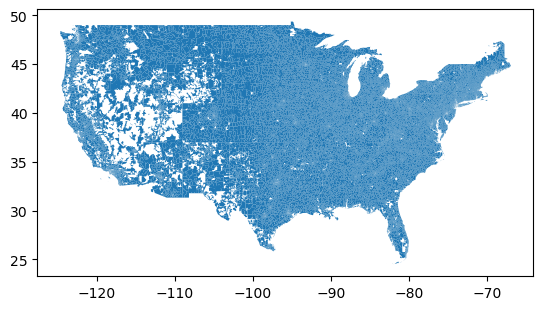

In [142]:
# plot data (this is just showing locations)
full_sp.plot()

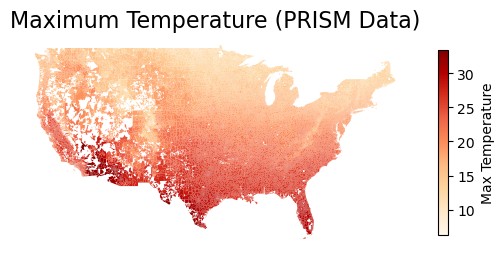

In [143]:
# plot max temp
fig, ax = plt.subplots(1,1)
full_sp.plot(column = 'max_temp',
            ax=ax, 
            legend = True,
            cmap = 'OrRd', 
            legend_kwds = {'label':"Max Temperature",
                          'orientation':"vertical",
                          'shrink': 0.5})

ax.set_title("Maximum Temperature (PRISM Data)", fontsize=16)
ax.set_axis_off()

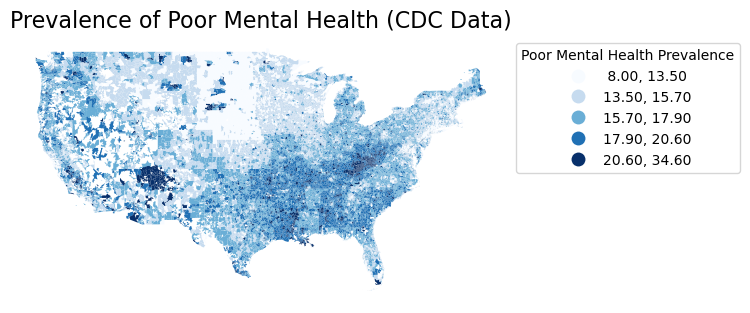

In [144]:
# poor mental health map
full_sp = full_sp.to_crs(epsg=4326)
fig, ax = plt.subplots(1, 1)
full_sp.plot(column='P_MNTHL',
            ax=ax, 
            legend=True, 
            cmap='Blues', 
            scheme='NaturalBreaks', 
            k=5, 
            legend_kwds={'title': 'Poor Mental Health Prevalence',
                        'loc': 'upper left',  # Set legend location inside the plot area
                        'bbox_to_anchor': (1, 1)})  # Move legend outside the plot to the right

ax.set_title("Prevalence of Poor Mental Health (CDC Data)", fontsize=16)
ax.set_axis_off()
plt.show()

In [148]:
full_sp['P_NEHD'].describe()  # remove -999 and convert to NA.

count    27093.000000
mean        12.519325
std          4.877667
min          0.200000
25%          9.200000
50%         12.900000
75%         16.000000
max         30.400000
Name: P_NEHD, dtype: float64

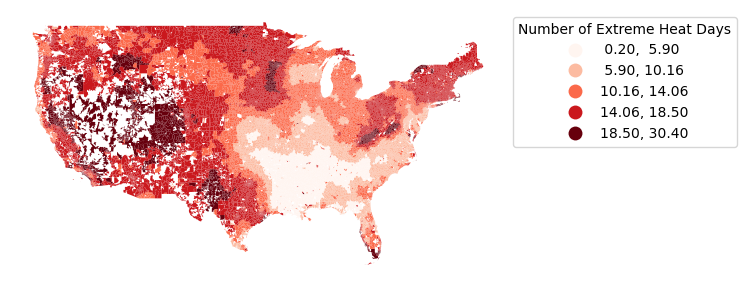

In [149]:
# extreme heat days map
full_sp.replace(-999, np.nan, inplace=True)
full_sp = full_sp.to_crs(epsg=4326)
fig, ax = plt.subplots(1, 1)
full_sp.plot(column='P_NEHD',
            ax=ax, 
            legend=True, 
            cmap='Reds', 
            scheme='NaturalBreaks', 
            k=5, 
            legend_kwds={'title': 'Number of Extreme Heat Days',
                        'loc': 'upper left',  # Set legend location inside the plot area
                        'bbox_to_anchor': (1, 1)})  # Move legend outside the plot to the right
ax.set_axis_off()
plt.show()

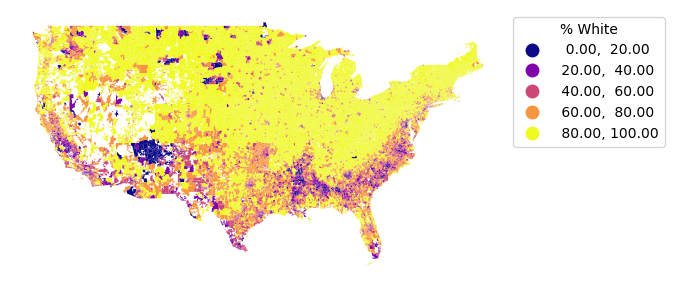

In [165]:
# plot % white
fig, ax = plt.subplots(1,1)
full_sp.plot(column = 'pct_white',
            ax=ax, 
            legend = True,
            cmap = 'plasma', 
            scheme='equal_interval', 
            k=5, 
            legend_kwds = {'title':"% White",
                          'loc': 'upper left',  # Set legend location inside the plot area
                        'bbox_to_anchor': (1, 1)})  # Move legend outside the plot to the right
ax.set_axis_off()


# 4. Analysis - Max Temp

### a. Queen's Contiguity Matrix 

In [49]:
# create matrix and standardize weights
w_queen = Queen.from_dataframe(full_sp, use_index=True)
w_queen.transform = 'r'

('WARNING: ', 253, ' is an island (no neighbors)')
('WARNING: ', 339, ' is an island (no neighbors)')
('WARNING: ', 346, ' is an island (no neighbors)')
('WARNING: ', 448, ' is an island (no neighbors)')
('WARNING: ', 535, ' is an island (no neighbors)')
('WARNING: ', 554, ' is an island (no neighbors)')
('WARNING: ', 573, ' is an island (no neighbors)')
('WARNING: ', 598, ' is an island (no neighbors)')
('WARNING: ', 938, ' is an island (no neighbors)')
('WARNING: ', 1097, ' is an island (no neighbors)')
('WARNING: ', 1104, ' is an island (no neighbors)')
('WARNING: ', 1126, ' is an island (no neighbors)')
('WARNING: ', 1130, ' is an island (no neighbors)')
('WARNING: ', 1155, ' is an island (no neighbors)')
('WARNING: ', 1205, ' is an island (no neighbors)')
('WARNING: ', 1214, ' is an island (no neighbors)')
('WARNING: ', 1822, ' is an island (no neighbors)')
('WARNING: ', 2398, ' is an island (no neighbors)')
('WARNING: ', 2432, ' is an island (no neighbors)')
('WARNING: ', 2461, '

/Applications/anaconda3/envs/final-project/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 132 disconnected components.
 There are 98 islands with ids: 253, 339, 346, 448, 535, 554, 573, 598, 938, 1097, 1104, 1126, 1130, 1155, 1205, 1214, 1822, 2398, 2432, 2461, 2472, 2477, 2518, 2539, 2547, 2551, 2577, 2631, 2635, 2648, 2649, 2662, 2666, 2680, 2685, 2704, 2718, 2730, 2745, 2761, 2765, 3810, 5750, 5983, 6471, 6780, 8385, 8389, 8391, 8663, 8702, 9805, 10397, 10479, 11442, 13884, 16178, 16200, 16211, 16217, 17691, 17956, 23109, 23725, 26842, 26843, 27241, 27871, 27908, 27913, 27952, 28218, 29295, 29330, 29389, 29390, 29391, 29400, 29411, 29416, 29482, 29603, 29728, 29924, 29925, 29969, 30420, 30435, 30557, 31658, 31674, 31729, 31739, 31755, 31766, 31767, 31786, 31838.
  W.__init__(self, neighbors, ids=ids, **kw)


### b. Moran's I calculation

In [50]:
# Calculate Moran's I using the same variable
moran = Moran(full_sp.P_MNTHL, w_queen)

print(f"Moran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")

Moran's I: 0.7084196619273377
p-value: 0.001


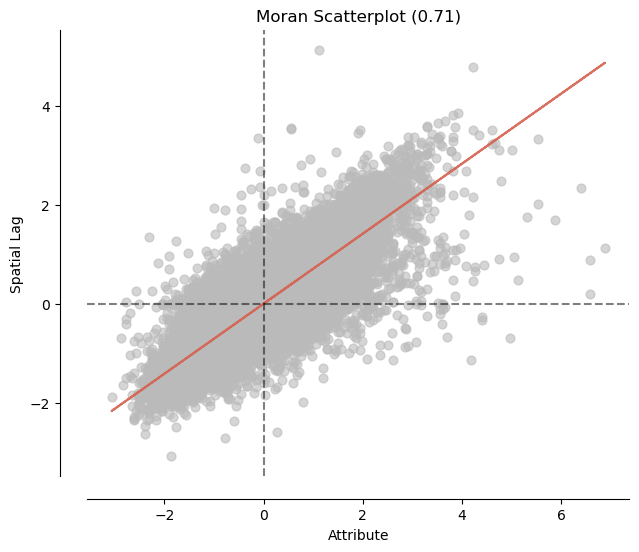

In [151]:
# create figure -- can see 0.09: tells me attribute and spatial lag. 
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

In [52]:
# get local moran's I
moran_loc = Moran_Local(full_sp.P_MNTHL, w_queen)

/Applications/anaconda3/envs/final-project/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


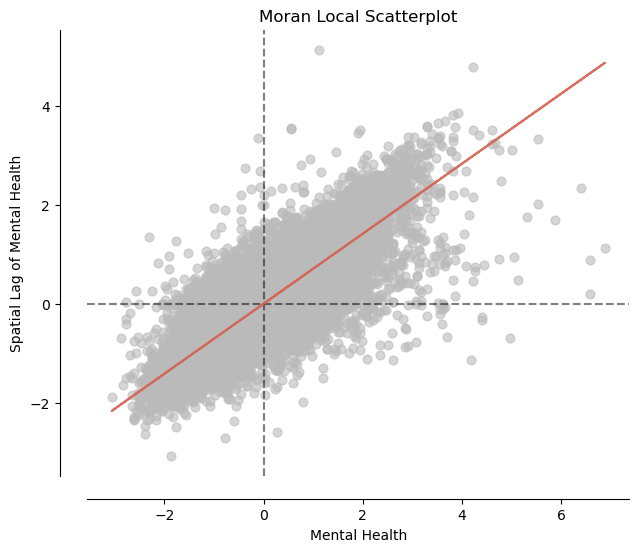

In [53]:
# plot local moran's I
fig, ax = moran_scatterplot(moran_loc)
ax.set_xlabel('Mental Health')
ax.set_ylabel('Spatial Lag of Mental Health')
plt.show()

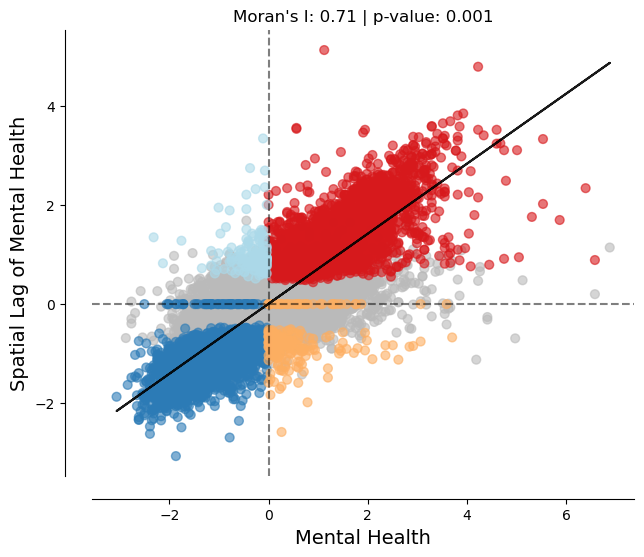

In [157]:
# based on colors that we naturally have attached to LISA clusters (high-high, low-low, high-low, low-high).
# if color attached it is statistically significant. if gray, not statistically significant.
# high high -- local value and spatial lag is higher than average (its average price is higher and its neighbors are higher than average)
# high-low is most expensive property on block
# next: we would want to map this we can see where these clusters are. 
# from a spatial regression perspective, means we have to control the spatial component in our model. 
# hot spots and cold spots are most important here
fig, ax = moran_scatterplot(moran_loc, p = 0.05, aspect_equal=True)
ax.set_xlabel('Mental Health', fontsize=14) 
ax.set_ylabel('Spatial Lag of Mental Health', fontsize=14)
plt.title(f"Moran's I: {moran.I:.2f} | p-value: {moran.p_sim:.3f}")
plt.show()

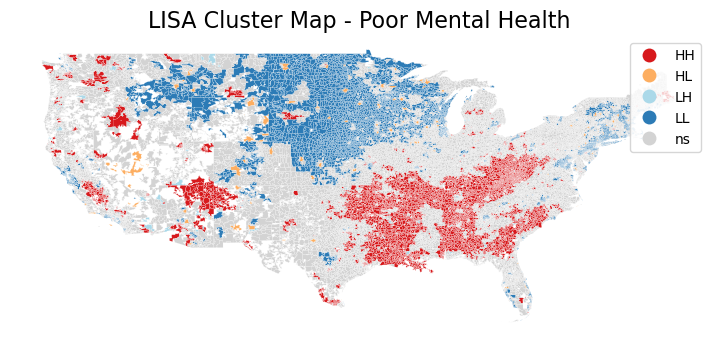

In [78]:
# map lisa clusters
# the high-low and low-high don't matter to us as much. since our moran's I is positive, we are more interested in the positive clustering (high-high, low-low)
# there are lots of insignificant places on the map (gray)
full_sp = full_sp.to_crs(epsg=4326)
lisa_cluster(moran_loc, full_sp, p=0.05, figsize = (9,9))
plt.title("LISA Cluster Map - Poor Mental Health", fontsize=16)
plt.show()

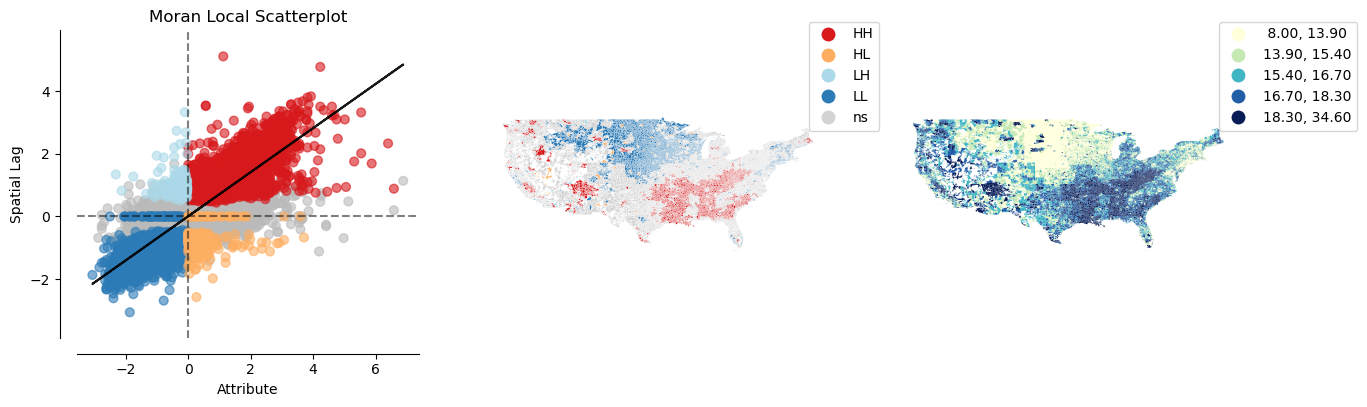

In [79]:
# plot autocorrelation
# scatter plot 
# where these datapoints are on geographic landscape
# underlying mental_health -- raw data
plot_local_autocorrelation(moran_loc, full_sp, full_sp.P_MNTHL)
plt.show()

### c. Max Temp Indicator

#### i. Global logistic model

In [80]:
full_sp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 27749 entries, 0 to 32194
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   STATE           27749 non-null  object  
 1   ZCTA            27749 non-null  object  
 2   P_MNTHL         27749 non-null  float64 
 3   P_NEHD          27749 non-null  float64 
 4   SOCIODEM_SCORE  27749 non-null  float64 
 5   P_IMPERV        27749 non-null  float64 
 6   P_TREEC         27749 non-null  float64 
 7   P_MOBILE        27749 non-null  float64 
 8   P_NOVEH         27749 non-null  float64 
 9   P_PM25          27749 non-null  float64 
 10  ZCTA5CE20       27749 non-null  object  
 11  geometry        27749 non-null  geometry
 12  max_temp        27749 non-null  float64 
 13  pct_white       27749 non-null  float64 
dtypes: float64(10), geometry(1), object(3)
memory usage: 3.2+ MB


In [81]:
# create series of independent variables 
# i know dependent variable is mental health
x = ['max_temp', 'SOCIODEM_SCORE', 'P_IMPERV', 'P_TREEC', 'P_MOBILE', 'P_NOVEH', 'P_PM25', 'pct_white']

In [82]:
x

['max_temp',
 'SOCIODEM_SCORE',
 'P_IMPERV',
 'P_TREEC',
 'P_MOBILE',
 'P_NOVEH',
 'P_PM25',
 'pct_white']

In [86]:
# create ols: linear model -- pr_sq_ft on x values
model_ols = spreg.OLS(full_sp[['P_MNTHL']].values, 
                      full_sp[x].values, 
                      name_y = 'P_MNTHL', name_x = x)

In [87]:
print(model_ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     P_MNTHL                Number of Observations:       27749
Mean dependent var  :     16.1969                Number of Variables   :           9
S.D. dependent var  :      2.6752                Degrees of Freedom    :       27740
R-squared           :      0.2171
Adjusted R-squared  :      0.2169
Sum squared residual:      155473                F-statistic           :    961.4336
Sigma-square        :       5.605                Prob(F-statistic)     :           0
S.E. of regression  :       2.367                Log likelihood        :  -63283.690
Sigma-square ML     :       5.603                Akaike info criterion :  126585.380
S.E of regression ML:      2.3670                Schwarz criterion     :  126659.459

------------------------------------------------------------

#### ii. Spatial regression model

In [88]:
# this is the spatial reg model using lag function
# w is our range_dist 
model_sp = spreg.GM_Lag(full_sp[['P_MNTHL']].values, full_sp[x].values, w = w_queen, name_y = 'P_MNTHL', name_x = x)

In [89]:
print(model_sp.summary)
# we can see max_temp (weighted) is significant. its negative, meaning we reversed spatial dependence in the model. 
# i controlled spatial dependence (max_temp), and now i can see relationships: 

# main effect of water_diff was almost always positive. places closer to cost tended to be more expensive
# for every 1 degree increase in max_temp....

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     P_MNTHL                Number of Observations:       27749
Mean dependent var  :     16.1969                Number of Variables   :          10
S.D. dependent var  :      2.6752                Degrees of Freedom    :       27739
Pseudo R-squared    :      0.4785
Spatial Pseudo R-squared:  0.2062

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        11.19590         0.18153        61.67670         0.00000
            max_temp         0.10801         0.00393        27.49054         0.00000
      SOCIODEM_SCORE         0.00169      

### d. Relative Extreme Heat Indicator

#### i. Global logistic model

In [90]:
full_sp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 27749 entries, 0 to 32194
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   STATE           27749 non-null  object  
 1   ZCTA            27749 non-null  object  
 2   P_MNTHL         27749 non-null  float64 
 3   P_NEHD          27749 non-null  float64 
 4   SOCIODEM_SCORE  27749 non-null  float64 
 5   P_IMPERV        27749 non-null  float64 
 6   P_TREEC         27749 non-null  float64 
 7   P_MOBILE        27749 non-null  float64 
 8   P_NOVEH         27749 non-null  float64 
 9   P_PM25          27749 non-null  float64 
 10  ZCTA5CE20       27749 non-null  object  
 11  geometry        27749 non-null  geometry
 12  max_temp        27749 non-null  float64 
 13  pct_white       27749 non-null  float64 
dtypes: float64(10), geometry(1), object(3)
memory usage: 3.2+ MB


In [91]:
# create series of independent variables 
# i know dependent variable is mental health
x = ['P_NEHD', 'SOCIODEM_SCORE', 'P_IMPERV', 'P_TREEC', 'P_MOBILE', 'P_NOVEH', 'P_PM25', 'pct_white']

In [92]:
x

['P_NEHD',
 'SOCIODEM_SCORE',
 'P_IMPERV',
 'P_TREEC',
 'P_MOBILE',
 'P_NOVEH',
 'P_PM25',
 'pct_white']

In [93]:
# create ols: linear model -- pr_sq_ft on x values
model_ols = spreg.OLS(full_sp[['P_MNTHL']].values, 
                      full_sp[x].values, 
                      name_y = 'P_MNTHL', name_x = x)

In [94]:
print(model_ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     P_MNTHL                Number of Observations:       27749
Mean dependent var  :     16.1969                Number of Variables   :           9
S.D. dependent var  :      2.6752                Degrees of Freedom    :       27740
R-squared           :      0.1591
Adjusted R-squared  :      0.1589
Sum squared residual:      166985                F-statistic           :    656.1033
Sigma-square        :       6.020                Prob(F-statistic)     :           0
S.E. of regression  :       2.453                Log likelihood        :  -64274.766
Sigma-square ML     :       6.018                Akaike info criterion :  128567.532
S.E of regression ML:      2.4531                Schwarz criterion     :  128641.611

------------------------------------------------------------

#### ii. Spatial regression model

In [95]:
# this is the spatial reg model using lag function
# w is our range_dist 
model_sp = spreg.GM_Lag(full_sp[['P_MNTHL']].values, full_sp[x].values, w = w_queen, name_y = 'P_MNTHL', name_x = x)

In [96]:
print(model_sp.summary)
# we can see max_temp (weighted) is significant. its negative, meaning we reversed spatial dependence in the model. 
# i controlled spatial dependence (max_temp), and now i can see relationships: 

# main effect of water_diff was almost always positive. places closer to cost tended to be more expensive
# for every 1 degree increase in max_temp....

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     P_MNTHL                Number of Observations:       27749
Mean dependent var  :     16.1969                Number of Variables   :          10
S.D. dependent var  :      2.6752                Degrees of Freedom    :       27739
Pseudo R-squared    :      0.6276
Spatial Pseudo R-squared:  0.0793

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         5.80762         0.23306        24.91927         0.00000
              P_NEHD         0.00010         0.00006         1.55330         0.12035
      SOCIODEM_SCORE         0.00025      